In [1]:
!pip install lightning
!pip install torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: starlette
    Found existing installation: starlette 0.26.1
    Uninstalling starlette-0.26.1:
      Successfully uninstalled starlette-0.26.1
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.95.0
    Uninstalling fastapi-0.95.0:
      Successfully uninstalled fastapi-0.95.0


In [2]:
import os
from shutil import rmtree

import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics.functional import accuracy
from torchsummary import summary
import lightning.pytorch as pl

import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import tqdm.notebook as tqdm
import time

import matplotlib.pyplot as plt
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
data_dir = "/kaggle/input/pokemonclassification/PokemonData"
pokemons = os.listdir(data_dir)

In [5]:
data_dict = {'filename':[], 'label':[]}
data_df = pd.DataFrame()
for i, pokemon in enumerate(pokemons):
    loc = os.path.join(data_dir, pokemon)
    for file in os.listdir(loc):
        if not file.endswith('.svg'):
            data_dict['filename'].append(os.path.join(loc, file))
            data_dict['label'].append(i)
data_df = shuffle(pd.DataFrame(data_dict)).reset_index()
data_df.drop('index', axis=1, inplace=True)
data_df.head()

,filename,label
0,/kaggle/input/pokemonclassification/PokemonDat...,2
1,/kaggle/input/pokemonclassification/PokemonDat...,9
2,/kaggle/input/pokemonclassification/PokemonDat...,121
3,/kaggle/input/pokemonclassification/PokemonDat...,101
4,/kaggle/input/pokemonclassification/PokemonDat...,17


In [6]:
train = pd.DataFrame()
validation = pd.DataFrame()
test = pd.DataFrame()
for label in range(len(pokemons)):
    a = data_df[data_df['label'] == label]
    b = np.split(a, [int(0.8*a.shape[0]), int(0.95*a.shape[0])])
    train = pd.concat([train, b[0]], axis=0)
    validation = pd.concat([validation, b[1]], axis=0)
    test = pd.concat([test, b[2]], axis=0)
#     print(len(index))
train_df = shuffle(train)
validation_df = shuffle(validation)
test_df = shuffle(test)

In [7]:
train_df.shape, validation_df.shape, test_df.shape

((5394, 2), (1007, 2), (424, 2))

## Using transfer learning
* loaded Pretrained resnet model and then modified last classification layers
* trained for few epochs to get the last layers train while base of the model was freezed
* trained the whole model with small learning rate

In [8]:
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()
model = resnet50(weights)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 70.3MB/s]


In [9]:
# model 
# summary(model, (3, 244, 244))

In [10]:
def preprocess(df):
    '''df is a dataframe'''
    res = []
    for idx, x in df.iterrows():
        filename = x['filename']
        label = x['label']
        im = Image.open(filename)
        try:
            im = transform(im)
            res.append((im, label))
        except :
            pass
    return res

sampling small set to avoide memory limit exceed error

In [11]:
train = preprocess(train_df.sample(3000))
validation = preprocess(validation_df.sample(500))
test = preprocess(test_df.sample(100))

In [12]:
len(train), len(validation), len(test)

(2955, 492, 98)

In [13]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, use_cache=False, preprocess=None):
        self.data = data
        self.use_cache = use_cache
        self.preprocess = preprocess
    def __getitem__(self, index):
        return self.data[index]
#         if self.use_cache and (index in self.cached_data):
#             return self.cached_data[index]
#         x = data[index]
#         if self.preprocess != None:
#             x = self.preprocess(x)
#         if self.use_cache:
#             self.cached_data[index] = x
#         return x
    def __len__(self):
        return len(self.data)

In [14]:
train_dataset = MyDataset(train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)#, num_workers=1, prefetch_factor=2)
val_dataset = MyDataset(validation)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)#, num_workers=1, prefetch_factor=2)
test_dataset = MyDataset(test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)#, num_workers=1, prefetch_factor=2)

In [15]:
batch = next(iter(train_dataloader))
batch[0].shape, batch[0][0].shape

(torch.Size([64, 3, 224, 224]), torch.Size([3, 224, 224]))

## getting my_model
* extracted base of resnet model with trained weights, (freezed weights)
* replaced and added the classification layer (trainable part)

In [16]:
modules = []
# i = 0
for i, layer in enumerate(model.children()):
    if i<9:
        modules.append(layer)
        for name, param in layer.named_parameters():
            param.requires_grad = False
modules.append(torch.nn.Flatten())
modules.append(torch.nn.Linear(in_features=2048, out_features=len(pokemons), bias=True))

In [17]:
my_model = torch.nn.Sequential(*modules)
my_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [18]:
summary(my_model, (3, 244, 244), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [19]:
batch_out = my_model(batch[0])
batch_out.shape

torch.Size([64, 150])

## Training
* defined a custom Task class to help in training

In [20]:
class Task():
    '''This class helps in efficiently training pytorch model easily'''
    def __init__(self, model, 
                 BASE_PATH,
                 train_dataloader, val_dataloader=None,  
                 DEVICE='cpu', 
                 lr=0.001):
        self.model = model.to(DEVICE)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.BASE_PATH = BASE_PATH #path where the output from training will be saved
        self.DEVICE = DEVICE #device type 'cuda' or 'cpu'
        self.lr = lr   # model learning rate
        self.optimizer = self.get_optimizer()
        self.scheduler = self.get_scheduler()
        self.version_dir = None
        self.history = {} # dictionary that stores loss and other metrices each epoch
    
    def get_scheduler(self):
        '''reurn a scheduler'''
        return None
    
    def get_loss(self, output, y):
        '''write the loss function here'''
        loss = torch.nn.functional.cross_entropy(output, y)
        return loss
    
    def get_optimizer(self):
        '''return optimizer'''
        return torch.optim.Adam(self.model.parameters(), self.lr)
    
    def get_version_dir(self):
        '''this function return the new folder name 
            for saving the output of current training run'''
        versions = [f.name for f in os.scandir(self.BASE_PATH) \
                    if f.is_dir() and f.name.startswith('Version')]
        curr_version = None
        if len(versions)==0:
            curr_version = 'Version0'
        else:
            curr_version = f'Version{int(versions[-1][7:])+1}'
        PATH = os.path.join(self.BASE_PATH, curr_version)
        if not os.path.exists(PATH):
           os.makedirs(PATH)
        print(f"The output for current run will be saved at {PATH}")
        return PATH
    
    def save_checkpoint(self, name, epoch):
        '''this function saves the checkpoint with the given parameter "name"'''
        # save model and history
        PATH = os.path.join(self.version_dir, name)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            }
        if self.scheduler:
            checkpoint['scheduler'] = self.scheduler.state_dict()
        torch.save(checkpoint, PATH)
                
    def load_checkpoint(self, PATH):
        '''this function load the checkpoint for given "PATH"'''
        checkpoint = torch.load(PATH)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint['history']
        if self.scheduler:
            self.scheduler.load_state_dict(checkpoin['scheduler'])
        return checkpoint['epoch']
    
    def train(self, max_epochs=25, 
              continue_training=False, continue_path=None, 
              validate_after_k=1, 
              save_after_k=-1):
        #get the directory to save output of current run
        self.version_dir = self.get_version_dir()
        
        best_accuracy = 0.0 #tracking avg validation accuracy for each epoch
        update_best = True
        
        start_epoch = 0
        # load trained model
        if continue_training:
            start_epoch = self.load_checkpoint(continue_path)
        
        for epoch in tqdm.trange(start_epoch, max_epochs):
            since = time.time()
            running_metrics = {}
            running_metrics.setdefault('train_loss', 0.0)
            running_metrics.setdefault('val_loss', 0.0)
            running_metrics.setdefault('val_accuracy', 0.0)

            #Training mode
            self.model.train()
            tqdm_loader = tqdm.tqdm(train_dataloader)
            for batch in tqdm_loader:
                tqdm_loader.set_description(f"Training Epoch {epoch}")
                self.optimizer.zero_grad() # zero the parameter gradients
                X, Y = batch[0].to(self.DEVICE), batch[1].to(self.DEVICE)
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = self.model(X)
                    loss = self.get_loss(outputs, Y)
                    loss.backward()
                    self.optimizer.step()
                # statistics
                running_metrics['train_loss'] += loss.item()
                tqdm_loader.set_postfix(training_loss=loss.item())

            #Validation mode
            validation_done = False
            if val_dataloader != None and ((epoch-start_epoch+1)%validate_after_k ==0):
                model.eval()
                tqdm_loader = tqdm.tqdm(val_dataloader)
                ratio = 1/len(val_dataloader)
                for batch in tqdm_loader:
                    tqdm_loader.set_description(f"Validating Epoch {epoch}")
                    X, Y = batch[0].to(DEVICE), batch[1].to(DEVICE)
                    # predict
                    outputs = self.model(X.to(DEVICE))
                    loss = self.get_loss(outputs, Y)
                    acc = accuracy(outputs, Y, task='multiclass', num_classes=150)
                    # statistics
                    running_metrics['val_loss'] += loss.item()
                    running_metrics['val_accuracy'] += (acc.item()*ratio)
                    tqdm_loader.set_postfix(validation_loss=loss.item())
                    tqdm_loader.set_postfix(validation_acc=acc.item())
                validation_done = True
                
                #define how to get the best and set (update_best=True/False) based on that
                if running_metrics['val_accuracy'] > best_accuracy:
                    best_accuracy = running_metrics['val_accuracy']
                    update_best = True
                else:
                    update_best = False

            for metric_name in running_metrics:
                if metric_name.startswith('val') and validation_done:
                    self.history.setdefault('val', {}).setdefault(metric_name, []).append(running_metrics[metric_name])
                else:
                    self.history.setdefault('train', {}).setdefault(metric_name, []).append(running_metrics[metric_name])
                    
            #save model
            if update_best:
                self.save_checkpoint('best', epoch)
            if save_after_k!=-1 and (epoch+1)%save_after_k==0:
                self.save_checkpoint(f'epoch{epoch}', epoch)
            if epoch == (max_epochs-1):
                self.save_checkpoint('last', epoch)
                
            time_elapsed = time.time() - since
            self.history.setdefault('times', []).append(time_elapsed)     # save times per-epoch
            print(f"Epoch {epoch} complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s", end=" ")
            print(f"with total training loss {self.history['train']['train_loss'][-1]}")

In [21]:
# rmtree('/kaggle/working/Version0')

### training

In [22]:
TRAIN_EPOCHS = 25
TRAIN_LR = 0.01

In [23]:
training_task = Task(model=my_model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                     BASE_PATH='/kaggle/working/', 
                     DEVICE=DEVICE, 
                     lr=TRAIN_LR)

In [24]:
training_task.train(max_epochs=TRAIN_EPOCHS, 
              validate_after_k=3,
              save_after_k = 5)

The output for current run will be saved at /kaggle/working/Version0


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 0 complete in 0m 10s with total training loss 143.8468496799469


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1 complete in 0m 7s with total training loss 8.15907547622919


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2 complete in 0m 8s with total training loss 2.015970079228282


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3 complete in 0m 6s with total training loss 1.2469972809776664


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4 complete in 0m 7s with total training loss 0.8148974701762199


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5 complete in 0m 8s with total training loss 0.6632968680933118


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6 complete in 0m 6s with total training loss 0.5804981300607324


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7 complete in 0m 7s with total training loss 0.46277318987995386


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8 complete in 0m 8s with total training loss 0.3957277820445597


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9 complete in 0m 6s with total training loss 0.4012355301529169


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10 complete in 0m 6s with total training loss 0.2633844113443047


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11 complete in 0m 7s with total training loss 0.30938362516462803


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12 complete in 0m 6s with total training loss 0.3488144699949771


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13 complete in 0m 6s with total training loss 0.38291555270552635


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14 complete in 0m 8s with total training loss 0.23726916196756065


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15 complete in 0m 6s with total training loss 0.40254452219232917


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16 complete in 0m 6s with total training loss 0.13865384890232235


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17 complete in 0m 8s with total training loss 0.24816503864713013


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18 complete in 0m 6s with total training loss 0.17917737632524222


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 19 complete in 0m 6s with total training loss 0.32593039493076503


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20 complete in 0m 7s with total training loss 0.17232954723294824


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 21 complete in 0m 7s with total training loss 0.3031036410247907


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 22 complete in 0m 7s with total training loss 0.1922919483622536


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23 complete in 0m 7s with total training loss 0.23487575340550393


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 24 complete in 0m 6s with total training loss 0.23705782130127773


### FInetuning the model
* unfreeze the whole model
* reduce the learning rate

In [25]:
for i, layer in enumerate(my_model.children()):
    for name, param in layer.named_parameters():
        param.requires_grad = True

In [26]:
summary(my_model, (3, 244, 244), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

enter the correct path for starting finetuning starting from previous best weights

In [27]:
FINETUNE_EPOCHS = 50
FINETUNE_LR = 0.001
CONTINUE_PATH = '/kaggle/working/Version0/best' #start finetuning from best training model

In [28]:
finetuning_task = Task(model=my_model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                     BASE_PATH='/kaggle/working/', 
                     DEVICE=DEVICE, 
                     lr=FINETUNE_LR)

In [29]:
finetuning_task.train(max_epochs=FINETUNE_EPOCHS, 
                      continue_training=True,
                      continue_path=CONTINUE_PATH,
                      validate_after_k=3,
                      save_after_k = -1)

The output for current run will be saved at /kaggle/working/Version1


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 22 complete in 0m 17s with total training loss 268.69337405252736


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 23 complete in 0m 16s with total training loss 225.83746337890625


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24 complete in 0m 18s with total training loss 196.70853900909424


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 25 complete in 0m 16s with total training loss 179.7176012992859


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 26 complete in 0m 17s with total training loss 163.1562159061432


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27 complete in 0m 17s with total training loss 152.1678557395935


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 28 complete in 0m 16s with total training loss 138.18830180168152


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 29 complete in 0m 17s with total training loss 123.73394870758057


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30 complete in 0m 17s with total training loss 111.57471764087677


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 31 complete in 0m 16s with total training loss 101.5537097454071


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 32 complete in 0m 16s with total training loss 89.6003167629242


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 33 complete in 0m 17s with total training loss 77.91553997993469


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 34 complete in 0m 17s with total training loss 67.84595990180969


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 35 complete in 0m 16s with total training loss 55.99751043319702


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 36 complete in 0m 17s with total training loss 46.231279134750366


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 37 complete in 0m 17s with total training loss 34.52300006151199


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 38 complete in 0m 16s with total training loss 31.65300327539444


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 39 complete in 0m 17s with total training loss 24.02221117913723


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 40 complete in 0m 16s with total training loss 14.163244724273682


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 41 complete in 0m 17s with total training loss 9.190745294094086


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 42 complete in 0m 17s with total training loss 7.4495407193899155


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 43 complete in 0m 16s with total training loss 6.333512835204601


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 44 complete in 0m 16s with total training loss 4.998335771262646


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 45 complete in 0m 17s with total training loss 4.141296394169331


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 46 complete in 0m 16s with total training loss 3.2406924199312925


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 47 complete in 0m 16s with total training loss 4.222752628847957


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 48 complete in 0m 17s with total training loss 2.815344735980034


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 49 complete in 0m 17s with total training loss 2.054903247859329


## Testing model
* get a new instance of model
* load trained weights on this new instance of model

In [30]:
test_model = torch.nn.Sequential(*modules)

In [31]:
chekpoint_to_load = '/kaggle/working/Version1/best'
checkpoint = torch.load(chekpoint_to_load)
test_model.load_state_dict(checkpoint['model_state_dict'])
# self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']
# if self.scheduler:
#     self.scheduler.load_state_dict(checkpoin['scheduler'])

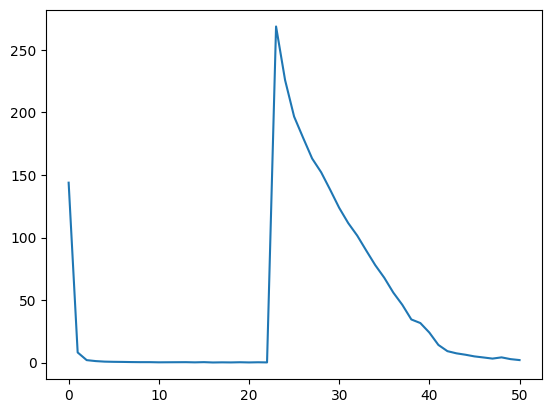

In [32]:
len(history['train']['train_loss'])
plt.plot(history['train']['train_loss'])

analysis of above chart
* the peak in the loss is when we unfreeze the model
* furthe training with samm lr might improve loss

In [33]:
def get_acc(model, test_dataloader):
    model.to('cpu')
    true_count = 0
    total_count = 0
    for i, batch in enumerate(test_dataloader):
        x, y = batch[0], batch[1]
        total_count += x.shape[0]
        y_predict = torch.argmax(torch.nn.Softmax(dim=1)(model(x)), dim=1)
#         print(1, y_predict.shape,y.shape, y_predict[0])
        true_count += sum(y_predict==y)
#         print(sum(y_predict==y))
    print(f"accuracy: {true_count/total_count}")
        

In [34]:
get_acc(test_model, train_dataloader)

accuracy: 0.9921875


In [35]:
get_acc(test_model, val_dataloader)

accuracy: 0.4000000059604645


In [36]:
get_acc(test_model, test_dataloader)

accuracy: 0.3265306055545807


## Model

training the model from scratch (not using pretrained weights)

In [37]:
# weights = ResNet50_Weights.DEFAULT
# transform = weights.transforms()
model_2 = resnet50()

In [38]:
modules = []
# i = 0
for i, layer in enumerate(model_2.children()):
    if i<9:
        modules.append(layer)
        for name, param in layer.named_parameters():
            param.requires_grad = False
modules.append(torch.nn.Flatten())
modules.append(torch.nn.Linear(in_features=2048, out_features=len(pokemons), bias=True))

In [39]:
my_model_2 = torch.nn.Sequential(*modules)

In [40]:
TRAIN_EPOCHS_2 = 50
TRAIN_LR_2 = 0.01

In [41]:
training_task_2 = Task(model=my_model_2, train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                     BASE_PATH='/kaggle/working/', 
                     DEVICE=DEVICE, 
                     lr=TRAIN_LR_2)

In [42]:
training_task_2.train(max_epochs=TRAIN_EPOCHS_2, validate_after_k=4)

The output for current run will be saved at /kaggle/working/Version1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 0 complete in 0m 6s with total training loss 3172.5999727249146


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1 complete in 0m 6s with total training loss 4271.546535491943


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2 complete in 0m 6s with total training loss 1816.9649848937988


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3 complete in 0m 7s with total training loss 880.2136898040771


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4 complete in 0m 6s with total training loss 836.4759654998779


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5 complete in 0m 6s with total training loss 874.5761852264404


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6 complete in 0m 6s with total training loss 950.4766216278076


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7 complete in 0m 6s with total training loss 759.6683902740479


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8 complete in 0m 5s with total training loss 904.931414604187


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9 complete in 0m 5s with total training loss 973.627498626709


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10 complete in 0m 5s with total training loss 968.6534976959229


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11 complete in 0m 6s with total training loss 1186.60933303833


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12 complete in 0m 5s with total training loss 1075.790512084961


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13 complete in 0m 5s with total training loss 1043.1643991470337


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14 complete in 0m 5s with total training loss 1094.0417156219482


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15 complete in 0m 7s with total training loss 1144.4961681365967


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16 complete in 0m 6s with total training loss 1182.354748725891


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 17 complete in 0m 6s with total training loss 1130.0094385147095


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18 complete in 0m 6s with total training loss 1099.7501049041748


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19 complete in 0m 7s with total training loss 1258.2227745056152


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 20 complete in 0m 6s with total training loss 967.7405281066895


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 21 complete in 0m 6s with total training loss 1068.3903903961182


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 22 complete in 0m 6s with total training loss 1117.053295135498


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23 complete in 0m 6s with total training loss 980.9878511428833


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 24 complete in 0m 5s with total training loss 1047.7489700317383


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 25 complete in 0m 5s with total training loss 1088.7060108184814


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 26 complete in 0m 5s with total training loss 1145.640085220337


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27 complete in 0m 6s with total training loss 979.855809211731


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 28 complete in 0m 5s with total training loss 883.6458711624146


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 29 complete in 0m 5s with total training loss 764.7886562347412


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 30 complete in 0m 5s with total training loss 859.1748361587524


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 31 complete in 0m 7s with total training loss 972.469030380249


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 32 complete in 0m 6s with total training loss 957.0121374130249


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 33 complete in 0m 6s with total training loss 958.2416019439697


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 34 complete in 0m 6s with total training loss 1090.1869707107544


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 35 complete in 0m 6s with total training loss 880.949746131897


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 36 complete in 0m 5s with total training loss 838.4338264465332


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 37 complete in 0m 5s with total training loss 903.4456129074097


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 38 complete in 0m 5s with total training loss 942.813042640686


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 39 complete in 0m 6s with total training loss 963.2848529815674


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 40 complete in 0m 5s with total training loss 972.9118022918701


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 41 complete in 0m 5s with total training loss 904.5819873809814


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 42 complete in 0m 5s with total training loss 1013.3875341415405


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 43 complete in 0m 7s with total training loss 1006.1829414367676


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 44 complete in 0m 6s with total training loss 799.6628456115723


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 45 complete in 0m 6s with total training loss 843.1925220489502


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 46 complete in 0m 6s with total training loss 783.388801574707


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 47 complete in 0m 6s with total training loss 818.0581722259521


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 48 complete in 0m 5s with total training loss 1102.0473279953003


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 49 complete in 0m 6s with total training loss 1140.0623016357422


testing

In [43]:
test_model_2 = torch.nn.Sequential(*modules)

chekpoint_to_load = '/kaggle/working/Version2/best'
checkpoint = torch.load(chekpoint_to_load)
test_model_2.load_state_dict(checkpoint['model_state_dict'])
# self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history_2 = checkpoint['history']
# if self.scheduler:
#     self.scheduler.load_state_dict(checkpoin['scheduler'])

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/Version2/best'

In [ ]:
len(history_2['train']['train_loss'])
plt.plot(history_2['train']['train_loss'])

In [ ]:
get_acc(test_model_2, test_dataloader)